In [5]:
# CartPole Env
import gym
import matplotlib as plt

class CartPoleEnv:
    def __init__(self):
        self.fps = 30
        self.env = gym.make('CartPole-v0')  # environment interface to game
        self.env.seed(42)
        self.env.reset()
        self.is_show = False
        self.current_sate = []
        self.is_done = False

    def render(self):
        self.env.render()
        
    def reset(self, is_show = False):
        state = self.env.reset()
        state = state.tolist()
        self.current_sate = state
        self.is_done = False
        self.is_show = is_show
        if self.is_show:
            self.env.render()

        return state
    
    def act(self, action):
        if self.is_show:
            self.env.render()
        # return observation, reward, done, info
        state, reward, is_done, info = self.env.step(self.get_action_set()[action])
        state = state.tolist()
        self.current_sate = state
        self.is_done = is_done
        return state, reward, is_done, info

    def get_num_actions(self):
        return 2

    def get_action_set(self):
        return [0, 1]

    def get_screen_rgb(self):
        pass

    def get_screen_gray(self):
        pass

    def get_num_state_features(self):
        return 4

    def get_state(self):
        return self.current_sate

    def is_over(self):
        return self.is_done


In [6]:
import numpy as np

class EpsilonGreedy:
    def __init__(self, epsilon, num_action, min_epsilon = 0.01, decay = 0.99):
        self.epsilon = epsilon
        self.num_action = num_action
        self.min_epsilon = min_epsilon
        self.decay = decay
        self.action_time = 0

    def select_action(self):
        self.action_time += 1
        if np.random.rand() < self.epsilon:
            self.update_epsilon()
            return np.random.choice(self.num_action)
        else: 
            self.update_epsilon()
            return -1
    
    def update_epsilon(self):
        self.epsilon = max(self.min_epsilon, min(0.5, 0.99**(self.action_time / 30)))
    
    def shutdown_explore(self):
        self.epsilon = 0

In [7]:
import tensorflow as tf
import numpy as np

class Agent:
    def __init__(self, state_size, num_action, reward_discount, learning_rate, exploration_strategy):
        self.state_size = state_size
        self.num_action = num_action
        self.reward_discount = reward_discount
        self.exploration_strategy = exploration_strategy
        self.iter = 0
        self.eps = 0
        self.data_type = tf.float32
        self.optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
        self.avg_loss = tf.keras.metrics.Mean(name = 'loss')
        self.model = self.build_model('model')
        self.is_shutdown_explore = False

        # For A2C loss function coefficients
        self.coef_entropy = 0
        self.coef_value = 1

    def build_model(self, name):
        # # Shared layers
        # nn_input = tf.keras.Input(shape = self.state_size, dtype = self.data_type)
        # x = tf.keras.layers.Dense(units = 64)(nn_input)
        # x = tf.keras.layers.ReLU()(x)
        # x = tf.keras.layers.Dense(units = 128)(x)
        # common = tf.keras.layers.ReLU()(x)

        # # Actor Model
        # actor_layer = tf.keras.layers.Dense(units = 64)(common)
        # actor_layer = tf.keras.layers.ReLU()(actor_layer)
        # actor_layer = tf.keras.layers.Dense(units = self.num_action)(actor_layer)
        # actor_nn_output = tf.keras.activations.softmax(actor_layer)

        # # Critic Model
        # critic_layer = tf.keras.layers.Dense(units = 64)(common)
        # critic_layer = tf.keras.layers.ReLU()(critic_layer)
        # critic_nn_output = tf.keras.layers.Dense(units = 1)(critic_layer)

        # # Combine into a model
        # model = tf.keras.Model(name = name, inputs = nn_input, outputs = [actor_nn_output, critic_nn_output])

        inputs = tf.keras.layers.Input(shape=self.state_size)
#         x = tf.keras.layers.Dense(128, activation="relu")(inputs)
        common = tf.keras.layers.Dense(128, activation="relu")(inputs)
        action = tf.keras.layers.Dense(self.num_action, activation="softmax")(common)
        critic = tf.keras.layers.Dense(1)(common)

        model = tf.keras.Model(inputs=inputs, outputs=[action, critic])

        return model

    def predict(self, state):
        return self.model(tf.convert_to_tensor(state, self.data_type))
    


    def loss(self, action_probs, critic_values, rewards):
        # Calculate accumulated reward Q(s, a) with discount
        np_rewards = np.array(rewards)
        num_reward = np_rewards.shape[0]
        discounts = np.logspace(0, num_reward, base = self.reward_discount, num = num_reward)
        
        q_values = np.zeros(num_reward)
        for i in range(num_reward):
            q_values[i] = np.sum(np.multiply(np_rewards[i:], discounts[:num_reward - i]))
        q_values = (q_values - np.mean(q_values)) / (np.std(q_values) + 1e-9)

        # Calculate the Actor Loss and Advantage A(s, a) = Q_value(s, a) - value(s)
        action_log_prbs = tf.math.log(action_probs)
        advs = q_values - critic_values
        actor_loss = -action_log_prbs * advs
        
        
        # Calculate the critic loss 
        huber = tf.keras.losses.Huber()
        critic_loss = huber(tf.convert_to_tensor(critic_values, dtype = self.data_type), tf.convert_to_tensor(q_values, dtype = self.data_type))

        # Calculate the cross entropy of action distribution
        entropy = tf.reduce_sum(action_probs * action_log_prbs * -1)
        
        # Compute loss as formular: loss = Sum of a trajectory(-log(Pr(s, a| Theta)) * Advantage + coefficient of value * Value - coefficient of entropy * cross entropy of action distribution)
        # Advantage: A(s, a) = Q_value(s, a) - value(s)
        # The modification refer to the implement of Baseline A2C from OpenAI
        # Update model with a trajectory Every time.
        return tf.reduce_sum(actor_loss + self.coef_value * critic_loss - self.coef_entropy * entropy)

    def get_metrics_loss(self):
        return self.avg_loss.result()
    
    def reset_metrics_loss(self):
        self.avg_loss.reset_states()

    def select_action(self, state):
        # Predict the probability of each action(Stochastic Policy)
        act_dist, value = self.predict([state])
        act_dist = tf.squeeze(act_dist)
        value = tf.squeeze(value)
        # Assume using Epsilon Greedy Strategy
        action = self.exploration_strategy.select_action()
        
        # If the index of action (return value) is -1, choose the action with highest probability that model predict
#         if action == -1 or self.shutdown_explore == True:
#             # Pick then action with HIGHTEST probability
#             act_idx = tf.argmax(act_dist, axis = 0).numpy()
#             return act_idx, act_dist, value
#         else:
#             # If the index of action (return value) is != -1, act randomly    
#             return action, act_dist, value
        return np.random.choice(self.num_action, p=np.squeeze(act_dist)), act_dist, value

    def shutdown_explore(self):
        self.is_shutdown_explore = True
        self.exploration_strategy.shutdown_explore()
    
    def update(self, loss, tape):
        gradients = tape.gradient(loss, self.model.trainable_variables)
        # gradients = [gradients if gradients is not None else tf.zeros_like(var) for var, grad in zip(self.model.trainable_variables, gradients)]
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        self.avg_loss.update_state(loss)

        # Update exploration rate of Epsilon Greedy Strategy
        self.exploration_strategy.update_epsilon()

        self.iter += 1
        self.eps += 1

    def train_on_env(self, env, is_show = False):
        with tf.GradientTape() as tape:
            tape.watch(self.model.trainable_variables)
            episode_reward = 0
            state = env.reset(is_show)

            action_probs = []
            critic_values = []
            rewards = []

            while not env.is_over():
                # env.render()
                action, act_prob_dist, value = self.select_action(state)
                
                act_prob = act_prob_dist[action]
                state_prime, reward, is_done, info = env.act(action)
                # print(f'State: {state}, Action: {action}, Reward: {reward}, State_Prime: {state_prime}')

                state = state_prime
                episode_reward += reward

                action_probs.append(act_prob)
                critic_values.append(value)
                rewards.append(reward)

            loss = self.loss(action_probs, critic_values, rewards)
            self.update(loss, tape)
            env.reset()

            return episode_reward, loss

4 Physical GPUs, 1 Logical GPUs
Episode 1



Avgerage Accumulated Reward: 24 | Loss: 12.148900985717773
Episode 21



Avgerage Accumulated Reward: 46 | Loss: 18.8170223236084
Episode 41



Avgerage Accumulated Reward: 61 | Loss: 25.725399017333984
Episode 61



Avgerage Accumulated Reward: 102 | Loss: 31.720775604248047
Episode 81



Avgerage Accumulated Reward: 117 | Loss: 28.90985679626465
Episode 101



Avgerage Accumulated Reward: 120 | Loss: 18.084636688232422
Episode 121



Avgerage Accumulated Reward: 151 | Loss: 42.25358200073242
Episode 141



Avgerage Accumulated Reward: 172 | Loss: 26.66937255859375
Episode 161



Avgerage Accumulated Reward: 187 | Loss: 29.5415096282959
Episode 181



Avgerage Accumulated Reward: 196 | Loss: 48.2578125
Episode 201



Avgerage Accumulated Reward: 185 | Loss: 52.57393264770508
Episode 221



Avgerage Accumulated Reward: 151 | Loss: 18.620136260986328
Episode 241



Avgerage Accumulated Reward: 187 | Loss: 35.090248107910156
Episode 261



Avgerage Accumulated Reward: 192 | Loss: 38.935508728027344
Episode 281



Avgerage Accumulated Reward: 200 | Loss: 48.818504333496094
Episode 301



Avgerage Accumulated Reward: 200 | Loss: 49.27289581298828
Episode 321



Avgerage Accumulated Reward: 197 | Loss: 43.152915954589844
Episode 341



Avgerage Accumulated Reward: 195 | Loss: 30.594669342041016
Episode 361



Avgerage Accumulated Reward: 196 | Loss: 53.95465850830078
Episode 381



Avgerage Accumulated Reward: 196 | Loss: 35.39226531982422
Episode 401



Avgerage Accumulated Reward: 200 | Loss: 52.132896423339844
Episode 421



Avgerage Accumulated Reward: 179 | Loss: 19.24551773071289
Episode 441



Avgerage Accumulated Reward: 195 | Loss: 36.260841369628906
Episode 461



Avgerage Accumulated Reward: 200 | Loss: 48.371009826660156
Episode 481



Avgerage Accumulated Reward: 187 | Loss: 51.05027389526367
Episode 501



Avgerage Accumulated Reward: 189 | Loss: 44.84046173095703
Episode 521



Avgerage Accumulated Reward: 196 | Loss: 28.04030990600586
Episode 541



Avgerage Accumulated Reward: 189 | Loss: 32.432395935058594
Episode 561



Avgerage Accumulated Reward: 190 | Loss: 24.490983963012695
Episode 581



Avgerage Accumulated Reward: 193 | Loss: 13.038902282714844
Episode 601



Avgerage Accumulated Reward: 195 | Loss: 27.04570960998535
Episode 621



Avgerage Accumulated Reward: 200 | Loss: 33.99336242675781
Episode 641



Avgerage Accumulated Reward: 200 | Loss: 19.909564971923828
Episode 661



Avgerage Accumulated Reward: 200 | Loss: 56.770484924316406
Episode 681



Avgerage Accumulated Reward: 199 | Loss: 62.82231903076172
Episode 701



Avgerage Accumulated Reward: 200 | Loss: 62.399131774902344
Episode 721



Avgerage Accumulated Reward: 200 | Loss: 53.15924835205078
Episode 741



Avgerage Accumulated Reward: 200 | Loss: 45.45025634765625
Episode 761



Avgerage Accumulated Reward: 200 | Loss: 59.40447998046875
Episode 781



Avgerage Accumulated Reward: 200 | Loss: 59.24421310424805
Episode 801



Avgerage Accumulated Reward: 199 | Loss: 56.34541702270508
Episode 821



Avgerage Accumulated Reward: 196 | Loss: 21.153654098510742
Episode 841



Avgerage Accumulated Reward: 193 | Loss: 28.813928604125977
Episode 861



Avgerage Accumulated Reward: 191 | Loss: 29.474140167236328
Episode 881



Avgerage Accumulated Reward: 200 | Loss: 27.328506469726562
Episode 901



Avgerage Accumulated Reward: 200 | Loss: 46.26395797729492
Episode 921



Avgerage Accumulated Reward: 198 | Loss: 42.614418029785156
Episode 941



Avgerage Accumulated Reward: 200 | Loss: 51.042423248291016
Episode 961



Avgerage Accumulated Reward: 200 | Loss: 56.758705139160156
Episode 981



Avgerage Accumulated Reward: 199 | Loss: 59.959312438964844
Episode 1001



Avgerage Accumulated Reward: 196 | Loss: 41.21056365966797
Episode 1021



Avgerage Accumulated Reward: 184 | Loss: 41.46380615234375
Episode 1041



Avgerage Accumulated Reward: 190 | Loss: 35.44264602661133
Episode 1061



Avgerage Accumulated Reward: 191 | Loss: 44.19203186035156
Episode 1081



Avgerage Accumulated Reward: 198 | Loss: 45.455589294433594
Episode 1101



Avgerage Accumulated Reward: 200 | Loss: 42.613868713378906
Episode 1121



Avgerage Accumulated Reward: 200 | Loss: 47.044002532958984
Episode 1141



Avgerage Accumulated Reward: 200 | Loss: 33.915367126464844
Episode 1161



Avgerage Accumulated Reward: 200 | Loss: 33.7115478515625
Episode 1181



Avgerage Accumulated Reward: 200 | Loss: 20.171619415283203
Episode 1201



Avgerage Accumulated Reward: 200 | Loss: 42.56952667236328
Episode 1221



Avgerage Accumulated Reward: 200 | Loss: 61.84162139892578
Episode 1241



Avgerage Accumulated Reward: 192 | Loss: 35.52693557739258
Episode 1261



Avgerage Accumulated Reward: 200 | Loss: 23.466054916381836
Episode 1281



Avgerage Accumulated Reward: 172 | Loss: 14.481897354125977
Episode 1301



Avgerage Accumulated Reward: 162 | Loss: 8.950993537902832
Episode 1321



Avgerage Accumulated Reward: 187 | Loss: 8.043258666992188
Episode 1341



Avgerage Accumulated Reward: 185 | Loss: 10.618870735168457
Episode 1361



Avgerage Accumulated Reward: 200 | Loss: 16.967798233032227
Episode 1381



Avgerage Accumulated Reward: 193 | Loss: 23.392345428466797
Episode 1401



Avgerage Accumulated Reward: 172 | Loss: 6.970348358154297
Episode 1421



Avgerage Accumulated Reward: 191 | Loss: 3.2840652465820312
Episode 1441



Avgerage Accumulated Reward: 200 | Loss: 18.354873657226562
Episode 1461



Avgerage Accumulated Reward: 200 | Loss: 43.215267181396484
Episode 1481



Avgerage Accumulated Reward: 176 | Loss: 68.91669464111328
Episode 1501



Avgerage Accumulated Reward: 192 | Loss: 14.106657028198242
Episode 1521



Avgerage Accumulated Reward: 200 | Loss: 29.654911041259766
Episode 1541



Avgerage Accumulated Reward: 200 | Loss: 16.894468307495117
Episode 1561



Avgerage Accumulated Reward: 200 | Loss: 32.2730712890625
Episode 1581



Avgerage Accumulated Reward: 200 | Loss: 0.6362912058830261
Episode 1601



Avgerage Accumulated Reward: 200 | Loss: 10.878840446472168
Episode 1621



Avgerage Accumulated Reward: 200 | Loss: 13.508638381958008
Episode 1641



Avgerage Accumulated Reward: 200 | Loss: 34.7498664855957
Episode 1661



Avgerage Accumulated Reward: 185 | Loss: -4.426549434661865
Episode 1681



Avgerage Accumulated Reward: 185 | Loss: 13.30035400390625
Episode 1701



Avgerage Accumulated Reward: 199 | Loss: 6.166097640991211
Episode 1721



Avgerage Accumulated Reward: 199 | Loss: 18.15808868408203
Episode 1741



Avgerage Accumulated Reward: 200 | Loss: 7.389034271240234
Episode 1761



Avgerage Accumulated Reward: 199 | Loss: 4.621337413787842
Episode 1781



Avgerage Accumulated Reward: 199 | Loss: 23.726966857910156
Episode 1801



Avgerage Accumulated Reward: 194 | Loss: 2.7167348861694336
Episode 1821



Avgerage Accumulated Reward: 200 | Loss: 27.235137939453125
Episode 1841



Avgerage Accumulated Reward: 200 | Loss: 14.357011795043945
Episode 1861



Avgerage Accumulated Reward: 200 | Loss: 14.330015182495117
Episode 1881



Avgerage Accumulated Reward: 200 | Loss: 50.10818099975586
Episode 1901



Avgerage Accumulated Reward: 200 | Loss: 20.416004180908203
Episode 1921



Avgerage Accumulated Reward: 200 | Loss: -6.764279842376709
Episode 1941



Avgerage Accumulated Reward: 200 | Loss: 40.80251693725586
Episode 1961



Avgerage Accumulated Reward: 195 | Loss: 28.285842895507812
Episode 1981



Accumulated Reward: 200 | Loss: 20.794048309326172
Evaluate
Accumulated Reward: 200.0


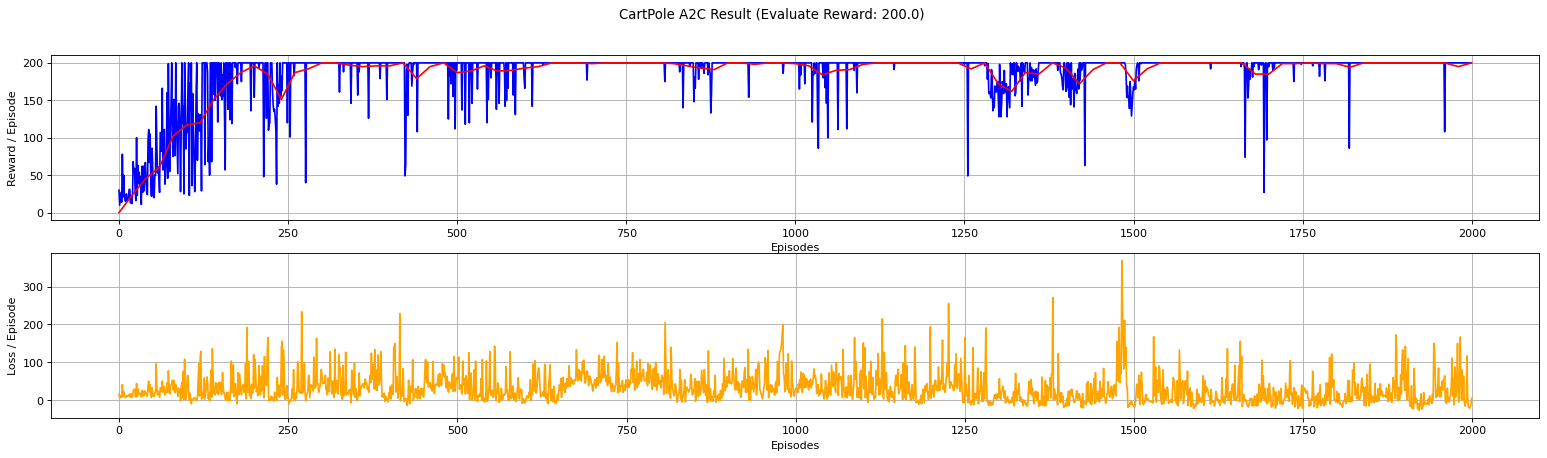

In [8]:
# CartPole-A2C Experiment
# 2020/08/11 SYC 

# import models.A2C as A2C
# import models.expStrategy.epsilonGreedy as EPSG
# import envs.cartPole as cartPole
import models.util as Util
import logging
import matplotlib.pyplot as plt
from matplotlib.pylab import figure
import numpy as np
# To run tqdm on notebook, import tqdm.notebook
from tqdm.notebook import tqdm
# Run on pure python
# from tqdm import tqdm

# Config Logging format
# logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)
# Config logging module to enable on notebook
# logger = logging.getLogger()
# logger.setLevel(logging.DEBUG)

# Test GPU and show the available logical & physical GPUs
Util.test_gpu()

env = CartPoleEnv()
NUM_STATE_FEATURES = env.get_num_state_features()
NUM_ACTIONS = env.get_num_actions()
EPISODE_NUM = 2000
PRINT_EVERY_EPISODE = 20
LEARNING_RATE = 0.003
REWARD_DISCOUNT = 0.99

exp_stg = EpsilonGreedy(0.2, NUM_ACTIONS)
agent = Agent((NUM_STATE_FEATURES, ), NUM_ACTIONS, REWARD_DISCOUNT, LEARNING_RATE, exp_stg)

state = env.reset()
accum_reward = 0

# tqdm progress bar
bar = []
# Reward & LossHistory
r_his = []
avg_r_his = [0]
loss_his = []
episode_reward = 0

print("Episode 1")
for episode in range(1, EPISODE_NUM + 1):
    if episode % PRINT_EVERY_EPISODE == 1:
        if episode > 1:
            bar.close()
            print("Avgerage Accumulated Reward: {} | Loss: {}".format(round(accum_reward / PRINT_EVERY_EPISODE), agent.get_metrics_loss()))
            print("Episode {}".format(episode))
            agent.reset_metrics_loss()
            avg_r_his.append(round(accum_reward / PRINT_EVERY_EPISODE))
            accum_reward = 0
        bar = tqdm(total = PRINT_EVERY_EPISODE)

    episode_reward, episode_loss = agent.train_on_env(env)
    accum_reward += episode_reward
    r_his.append(episode_reward)
    loss_his.append(episode_loss)
    
    episode_reward = 0

    bar.update(1)        
    env.reset()

bar.close()    
print("Accumulated Reward: {} | Loss: {}".format(round(accum_reward / PRINT_EVERY_EPISODE), agent.get_metrics_loss()))
avg_r_his.append(round(accum_reward / PRINT_EVERY_EPISODE))
agent.reset_metrics_loss()

# Evaluate the model
agent.shutdown_explore()
agent.reset_metrics_loss()
# Reset Game
env_state = env.reset()
accum_reward = 0

while not env.is_over():
    # env.render()
    action, act_log_prob, value = agent.select_action(state)
    state_prime, reward, is_done, info = env.act(action)

    state = state_prime
    accum_reward += reward

print("Evaluate")
print("Accumulated Reward: {}".format(accum_reward))

# Plot Reward History
# figure(num=None, figsize=(24, 6), dpi=80)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 6), dpi=80)
fig.suptitle(f'CartPole A2C Result (Evaluate Reward: {accum_reward})')
x_datas = range(0, len(r_his))
avg_x_datas = range(0, EPISODE_NUM + 1, PRINT_EVERY_EPISODE)

ax1.plot(x_datas, r_his, color='blue')
ax1.plot(avg_x_datas, avg_r_his, color='red')
ax1.set_xlabel('Episodes')
ax1.set_ylabel('Reward / Episode')
ax1.grid()

ax2.plot(x_datas, loss_his, color='orange')
ax2.set_xlabel('Episodes')
ax2.set_ylabel('Loss / Episode')
ax2.grid()

plt.savefig('CartPole-A2C-res.svg')
plt.show()